# Digit Recognizer


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

# Data Loading

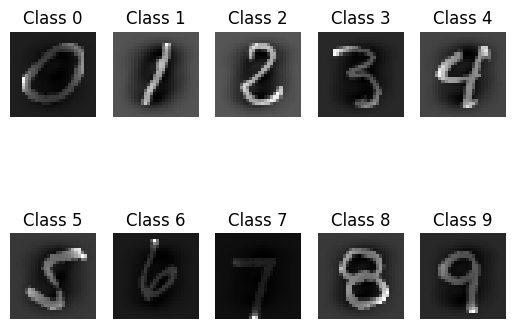

In [2]:
# read the train file
df = pd.read_csv('train.csv')

# split the data into features and labels
X = df.drop('label', axis=1)
y = df['label']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# display 1 example from each class
fig, ax = plt.subplots(2, 5)
for i in range(10):
    ax[i//5, i%5].imshow(X_train[y_train == i][0].reshape(28, 28), cmap='gray')
    ax[i//5, i%5].set_title(f'Class {i}')
    ax[i//5, i%5].axis('off')
plt.show()

In [3]:
# read the test file
test = pd.read_csv('test.csv')

# scale the test data
test = scaler.transform(test)

# print the shape of the data
print(f'Training data shape: {X_train.shape}')
print(f'Testing data shape: {X_test.shape}')
print(f'Test data shape: {test.shape}')

Training data shape: (33600, 784)
Testing data shape: (8400, 784)
Test data shape: (28000, 784)


# Support Vector Classification

In [4]:
# train the model
model = SVC()
model.fit(X_train, y_train)

# evaluate the model
predictions = model.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[801   0   3   0   1   3   7   0   1   0]
 [  0 892   8   1   1   1   1   2   2   1]
 [  2   6 820   3   4   0   4   2   5   0]
 [  1   3  11 885   0  11   0   9  12   5]
 [  1   0  11   0 805   1   5   4   0  12]
 [  2   1   8  14   1 663  10   1   2   0]
 [  5   1  11   0   0   6 760   0   2   0]
 [  0   2  12   3   5   2   0 854   1  14]
 [  1   4   9  10   4  10   4   2 789   2]
 [  2   2   7  12   7   3   0  19   4 782]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       816
           1       0.98      0.98      0.98       909
           2       0.91      0.97      0.94       846
           3       0.95      0.94      0.95       937
           4       0.97      0.96      0.97       839
           5       0.95      0.94      0.95       702
           6       0.96      0.97      0.96       785
           7       0.96      0.96      0.96       893
           8       0.96      0.94      0.95       835
           9       0.96     

In [5]:
# predict the labels
predictions = model.predict(test)

# write the predictions to a csv file
submission = pd.DataFrame({'ImageId': range(1, len(predictions)+1), 'Label': predictions})
submission.to_csv('submission_svc.csv', index=False)

#### Acc: 0.95825

# NN

In [6]:
# convert the data to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.int64)

# create a dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# create a dataloader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = Net()

# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# train the model
for epoch in range(10):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

# evaluate the model
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        _, predicted = torch.max(output, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f'Accuracy: {correct/total}')

# print confusion matrix and classification report
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        _, predicted = torch.max(output, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(y_batch.numpy())

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy: 0.9685714285714285
[[797   0   4   1   0   3   6   3   1   1]
 [  0 895   3   0   0   1   0   5   5   0]
 [  2   6 811   2   6   1   3   4   8   3]
 [  1   0   5 898   0  11   0   6  11   5]
 [  2   1   1   0 810   3   7   4   1  10]
 [  1   1   0  10   1 677   3   1   4   4]
 [  2   1   1   0   1  11 765   1   3   0]
 [  0   0   4   4   5   2   0 870   1   7]
 [  0   3   3   7   2   8   2   2 805   3]
 [  1   1   0   5   9   3   0   8   3 808]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       816
           1       0.99      0.98      0.99       909
           2       0.97      0.96      0.97       846
           3       0.97      0.96      0.96       937
           4       0.97      0.97      0.97       839
           5       0.94      0.96      0.95       702
           6       0.97      0.97      0.97       785
           7       0.96      0.97      0.97       893
           8       0.96      0.96      0.96       835

In [8]:
test_nn = torch.tensor(test, dtype=torch.float32)
predictions = model(test_nn)
_, predictions = torch.max(predictions, 1)

submission = pd.DataFrame({'ImageId': range(1, len(predictions)+1), 'Label': predictions})
submission.to_csv('submission_nn.csv', index=False)

#### Acc: 0.96557

# NN with dropout

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
model = Net()

# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# train the model
for epoch in range(10):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

# evaluate the model
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        _, predicted = torch.max(output, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f'Accuracy: {correct/total}')

# print confusion matrix and classification report
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        _, predicted = torch.max(output, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(y_batch.numpy())

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))


Accuracy: 0.9701190476190477
[[799   0   2   2   1   2   5   1   3   1]
 [  0 896   2   1   1   0   2   1   5   1]
 [  0   7 812   3   7   1   5   3   7   1]
 [  1   1   2 901   0  12   0   4  10   6]
 [  1   0   0   0 822   1   7   0   0   8]
 [  1   0   0   9   1 681   7   0   2   1]
 [  3   1   0   0   5   1 772   0   3   0]
 [  0   4   4   4   7   1   0 857   2  14]
 [  0   3   4   7   5   4   2   2 806   2]
 [  1   1   1   5  14   4   0   7   2 803]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       816
           1       0.98      0.99      0.98       909
           2       0.98      0.96      0.97       846
           3       0.97      0.96      0.96       937
           4       0.95      0.98      0.97       839
           5       0.96      0.97      0.97       702
           6       0.96      0.98      0.97       785
           7       0.98      0.96      0.97       893
           8       0.96      0.97      0.96       835

In [10]:

test_nn = torch.tensor(test, dtype=torch.float32)
predictions = model(test_nn)

_, predictions = torch.max(predictions, 1)

submission = pd.DataFrame({'ImageId': range(1, len(predictions)+1), 'Label': predictions})
submission.to_csv('submission_nn2.csv', index=False)

#### Acc: 0.96825